# T1: Single slice simulation on DLPFC dataset

In [1]:
import scanpy as sc
import torch
import urllib.request
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler
from torch_geometric.loader import NeighborLoader
from stadiffuser import pipeline
from stadiffuser.vae import SpaAE
from stadiffuser.models import SpaUNet1DModel
from stadiffuser import utils as sutils
from stadiffuser import metrics
warnings.filterwarnings("ignore")

In [2]:
# download data, save it in the same folder
url = "https://drive.google.com/uc?export=download&id=1Jal1XfMjiUqiiwWp4zraWHW8txff0eUQ"
filename = "adata_raw.h5ad"
urllib.request.urlretrieve(url, filename)
# If encounter errors, please download the file from https://drive.google.com/file/d/1Jal1XfMjiUqiiwWp4zraWHW8txff0eUQ/view?usp=drive_link manually.

('adata_raw.h5ad', <http.client.HTTPMessage at 0x150444b4850>)

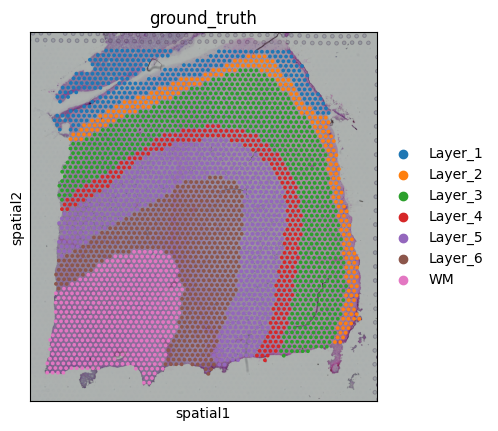

AnnData object with n_obs × n_vars = 3431 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'circle-1', 'circle-2', 'circle-3', 'rectangle-1', 'rectangle-2', 'rectangle-3', 'extrapolation-1', 'extrapolation-2', 'extrapolation-3', 'random_0.05', 'random_0.1', 'random_0.2', 'random_0.3', 'random_0.4', 'random_0.5', 'random_0.6', 'random_0.8', 'random_0.9', 'strip'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'spatial', 'spatial_net', 'ground_truth_colors'
    obsm: 'spatial'

In [2]:
adata_raw = sc.read_h5ad("adata_raw.h5ad")
# viualize the data
sc.pl.spatial(adata_raw, color="ground_truth")
adata_raw

## Data proprocessing

In [3]:
adata_processed = adata_raw.copy()
sc.pp.normalize_total(adata_processed, target_sum=1e4)
sc.pp.log1p(adata_processed)
adata_processed = sutils.cal_spatial_net2D(adata_processed, rad_cutoff=150)
# save to disk
adata_processed.write_h5ad("adata_processed.h5ad")

------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 19966 edges, 3431 cells, 5.8193 neighbors per cell on average.


## Train graph attention autoencoder

In [4]:
# prepare dataset for training
device = torch.device("cuda:0") # specify used device
autoencoder = SpaAE(input_dim=adata_processed.shape[1], gat_dim=[512, 32], block_out_dims=[32, 32]).to(device)
data = pipeline.prepare_dataset(adata_processed)
train_loader =  NeighborLoader(data, num_neighbors=[5, 3], batch_size=256)
autoencoder, loss = pipeline.train_autoencoder(train_loader, autoencoder, n_epochs=500, save_dir=".",
                                         device="cuda:0",
                                         model_name="atuoencoder")

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
import time
from tqdm import tqdm_notebook
example_iter = [1,2,3,4,5]
for rec in tqdm_notebook(example_iter):
    time.sleep(.1)

  0%|          | 0/5 [00:00<?, ?it/s]

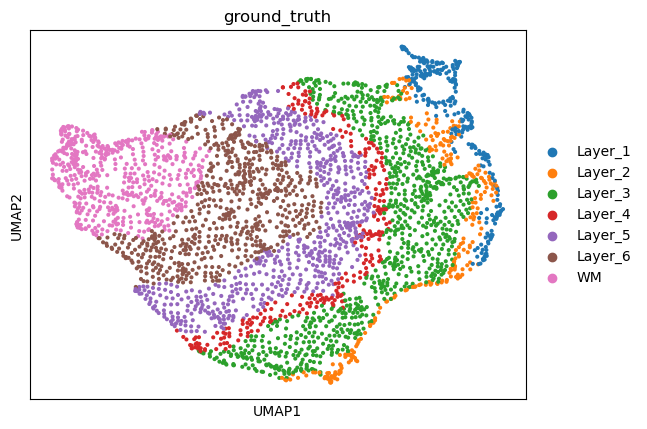

In [29]:
# get reconsturct
adata_recon = pipeline.get_recon(adata_processed, autoencoder, apply_normalize=False)
sc.pp.neighbors(adata_recon, use_rep="latent")
sc.tl.umap(adata_recon, min_dist=0.5)
sc.pl.umap(adata_recon, color="ground_truth")

## Train latent diffusion model

In [31]:
# Nomarlize the latent variables by min-max to [-1, 1]
normalizer = sutils.MinMaxNormalize(adata_recon.obsm["latent"], dim=0)
adata_recon.obsm["normalized_latent"] = normalizer.normalize(adata_recon.obsm["latent"])
# Convert the spatial coordination to the new spatial coordination
spatial_new = adata_recon.obsm["spatial"].copy()
# Divide the spatial coordinates by a factor
spatial_new = sutils.quantize_coordination(spatial_new, methods=[("division", 125), ("division", 125)])
adata_recon.obsm["spatial_new"] = spatial_new

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.008, mean deviation: 0.2500588749635675, pearson correlation: 0.999850876493874
Quantize 1th dimension of spatial coordinates to 0.008, mean deviation: 0.25002856310113675, pearson correlation: 0.9998722429659385


In [37]:
data_latent = pipeline.prepare_dataset(adata_recon, use_rep="normalized_latent", use_spatial="spatial_new",
                                       use_net="spatial_net")
train_loader =  NeighborLoader(data_latent, num_neighbors=[5, 3], batch_size=512)
# The denoiser model input channles = 16 (time embedding channels) + 1 (latent embedding channels)
denoiser = SpaUNet1DModel(in_channels=17, out_channels=1).to(device)
# Use DDPM scheduler to add noise gradually
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
denoiser, denoise_loss = pipeline.train_denoiser(train_loader, denoiser, noise_scheduler,
                                                 lr=1e-4, weight_decay=1e-6,
                                                 n_epochs=1000,
                                                 device=device)

  0%|          | 0/1000 [00:00<?, ?it/s]

-------------------Training Finished-------------------


### Simulate data from the denoiser

In [39]:
adata_sim = pipeline.simulate(denoiser, autoencoder, device=device,
                              use_net="spatial_net", ref_data=adata_recon, spatial_coord=adata_recon.obsm["spatial_new"],
                              seed=2024, normarlizer=normalizer)

  0%|          | 0/1000 [00:00<?, ?it/s]

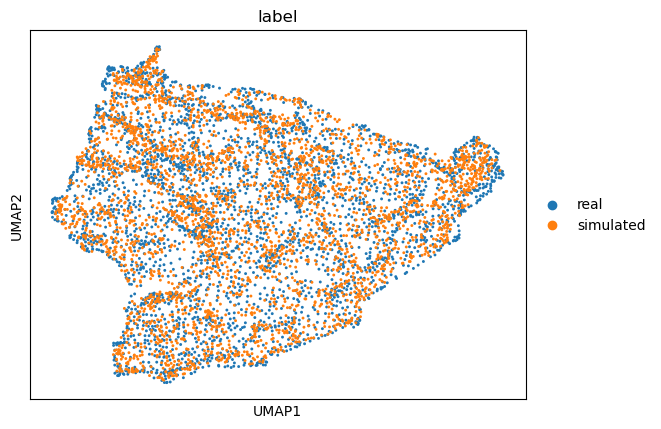

In [43]:
# concat the real and simulated data
adata_cat = sc.concat([adata_recon, adata_sim])
adata_cat.obs["label"] = ["real"] * adata_recon.shape[0] + ["simulated"] * adata_sim.shape[0]
sc.pp.neighbors(adata_cat, n_neighbors=15, use_rep="latent")
sc.tl.umap(adata_cat, min_dist=0.5)
sc.pl.umap(adata_cat, color="label")

Text(0.5, 0, 'STADiffuser w.o. labels')

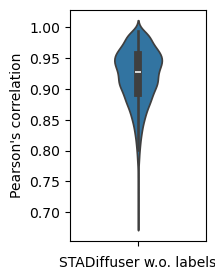

In [61]:
stadiff_corr = metrics.compute_corr(adata_sim, adata_recon, dim="gene")
# plot violin plot
fig, ax = plt.subplots(1, 1, figsize=(1.75, 3))
sns.violinplot(stadiff_corr, ax=ax, width=0.35)
ax.set_ylabel("Pearson's correlation")
ax.set_xlabel("STADiffuser w.o. labels")

## Train latent model with labels

In [65]:
import numpy as np
label_name = "ground_truth"
adata_train = adata_recon[~adata_processed.obs[label_name].isna()]
num_class_embeds = len(np.unique(adata_train.obs[label_name]))
class_dict = dict(zip(np.unique(adata_train.obs[label_name]), range(num_class_embeds)))
adata_train.obs["label_"] = adata_train.obs[label_name].map(class_dict)
data_latent = pipeline.prepare_dataset(adata_train, use_rep="normalized_latent", use_spatial="spatial_new",
                                               use_net="spatial_net", use_label="label_")
train_loader = NeighborLoader(data_latent, num_neighbors=[5, 3], batch_size=256)
denoiser_label = SpaUNet1DModel(in_channels=17, out_channels=1, num_class_embeds=num_class_embeds).to(device)

In [66]:
denoiser_label, denoise_label_loss = pipeline.train_denoiser(train_loader, denoiser_label, noise_scheduler,
                                                             lr=1e-4, weight_decay=1e-6,
                                                             n_epochs=1000,
                                                             num_class_embeds=num_class_embeds,
                                                             device=device)

  0%|          | 0/1000 [00:00<?, ?it/s]

-------------------Training Finished-------------------


### Simulate data from the conditional denoiser

In [70]:
adata_sim_label = pipeline.simulate(denoiser_label, autoencoder, device=device, labels=adata_train.obs["label_"].to_numpy(),
                              use_net="spatial_net", ref_data=adata_recon, spatial_coord=adata_recon.obsm["spatial_new"],
                              seed=2024, normarlizer=normalizer)

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 0, 'STADiffuser w. labels')

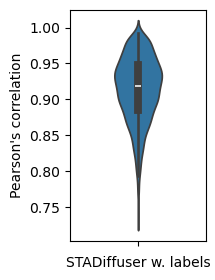

In [71]:
stadiff_corr = metrics.compute_corr(adata_sim_label, adata_recon, dim="gene")
fig, ax = plt.subplots(1, 1, figsize=(1.75, 3))
sns.violinplot(stadiff_corr, ax=ax, width=0.35)
ax.set_ylabel("Pearson's correlation")
ax.set_xlabel("STADiffuser w. labels")